In [55]:
import torch 
import torch.nn as nn
import torch.nn.functional as F

from utils.dataset import cifar10_dataset, cifar100_dataset
from models import resnet, vgg, mobilenet, googlenet, densenet

import numpy as np 
import seaborn as sns
from sklearn.metrics import normalized_mutual_info_score
from scipy.stats import pearsonr

import os 

%load_ext autoreload
%autoreload 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
def load_model(model, state_dict_path, print_layers=False):
    state_dict = torch.load(state_dict_path, map_location=device)
    model.load_state_dict(state_dict)
    model.to(device)
    if print_layers:
        for key in state_dict.keys():
            print(key)
    return model


# fetch embedding features of batches*64 samples
def fetch_features(model, model_ic, data_loader, batches = 1):
    
    non_IC_features = []
    IC_features = []
    
    def forward_hook(module, data_inputs, data_outputs):
        nonlocal non_IC_features

        data_inputs_copy = torch.transpose(data_inputs[0].detach(), 0, 1)
        for i, data_input in enumerate(data_inputs_copy):
            data_input = data_input.cpu().numpy()
            if len(non_IC_features) == 64:
                non_IC_features[i] = np.hstack((non_IC_features[i], data_input))
            else:
                non_IC_features.append(data_input)

            
    def forward_hook_ic(module, data_inputs, data_outputs):
        nonlocal IC_features

        data_inputs_copy = torch.transpose(data_inputs[0].detach(), 0, 1)
        for i, data_input in enumerate(data_inputs_copy):
            data_input = data_input.cpu().numpy()
            if len(IC_features) == 64:
                IC_features[i] = np.hstack((IC_features[i], data_input))
            else:
                IC_features.append(data_input)

    handler = model.linear.register_forward_hook(forward_hook)
    handler_ic = model_ic.linear.register_forward_hook(forward_hook_ic)
    
    for i, (images, labels) in enumerate(data_loader):
        images = images.to(device)
        if i==batches:
            break
        else: 
            model(images)
            model_ic(images)

    handler.remove()
    handler_ic.remove()
    
    return non_IC_features, IC_features

# compute per-sample dependence, based on metric func
def compute_dependence(func, features):
    num_feats = len(features)
    mutual_mat = np.empty([num_feats, num_feats])
    for i, feature_1 in enumerate(features):
        for j, feature_2 in enumerate(features):
            mutual_info = abs(func(feature_1, feature_2)[0])
            mutual_mat[i,j] = mutual_info
    return mutual_mat

def run_experiment(model, model_ic, data_loader, batches=20):
    non_IC_features, IC_features = fetch_features(model, model_ic, data_loader, batches)
    mat = compute_dependence(pearsonr, non_IC_features)
    mat_ic = compute_dependence(pearsonr, IC_features)
    return {"res_non_ic": mat, "res_ic": mat_ic}
    
    
    

In [57]:
%ls res/models

model_dir = "./res/models"

densenet40/  googlenet/  resnet110/  vgg16/


In [58]:
# resnet 110 series

# Cifar 10 

print("Experiment: model: resnet110; dataset: cifar10")

model = load_model(
    resnet.resnet110(num_classes=10),
    os.path.join(model_dir, "resnet110/cifar10_resnet110_best.pth"), 
#     True, 
)

model_ic = load_model(
    resnet.resnet110_ic(num_classes=10),
    os.path.join(model_dir, "resnet110/cifar10_resnet110_ic_best.pth"),
#     True, 
)

_, test_loader = cifar10_dataset()

res = run_experiment(model, model_ic, test_loader)
res_non_ic = res["res_non_ic"]
res_ic = res["res_ic"]

Experiment: model: resnet110; dataset: cifar10
INFO: Creating resnet110 model
INFO: Creating resnet110 model with IC layer
INFO: Loading CIFAR10 training dataset
Files already downloaded and verified
INFO: Loading CIFAR10 test dataset
Files already downloaded and verified


results of model w/o IC
0.21105200649431155


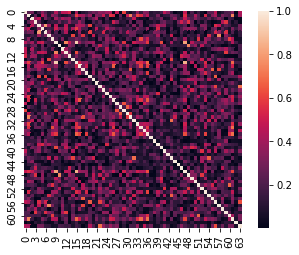

In [59]:
# res_non_ic
print("results of model w/o IC")
sns.heatmap(data=res_non_ic, square=True)
print(np.mean(res_non_ic))

results of model with IC
0.19087411219894893


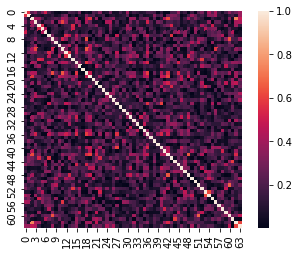

In [60]:
# res_ic
print("results of model with IC")
sns.heatmap(data=res_ic, square=True)
print(np.mean(res_ic))

In [61]:
# Cifar 100

print("Experiment: model: resnet110; dataset: cifar100")

model = load_model(
    resnet.resnet110(num_classes=100),
    os.path.join(model_dir, "resnet110/cifar100_resnet110_best.pth"),
#     True, 
)

model_ic = load_model(
    resnet.resnet110_ic(num_classes=100),
    os.path.join(model_dir, "resnet110/cifar100_resnet110_ic_best.pth"),
#     True, 
)

_, test_loader = cifar100_dataset()

res = run_experiment(model, model_ic, test_loader)
res_non_ic = res["res_non_ic"]
res_ic = res["res_ic"]

Experiment: model: resnet110; dataset: cifar100
INFO: Creating resnet110 model
INFO: Creating resnet110 model with IC layer
INFO: Loading CIFAR100 training dataset
Files already downloaded and verified
INFO: Loading CIFAR100 test dataset
Files already downloaded and verified


results of model w/o IC
0.11036842972891221


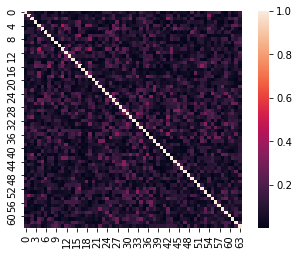

In [62]:
# res_non_ic
print("results of model w/o IC")
sns.heatmap(data=res_non_ic, square=True)
print(np.mean(res_non_ic))

results of model with IC
0.09860190514131623


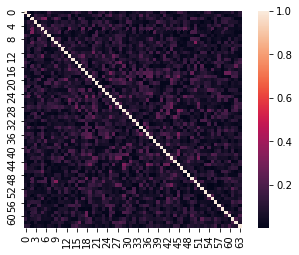

In [63]:
# res_ic
print("results of model with IC")
sns.heatmap(data=res_ic, square=True)
print(np.mean(res_ic))

In [64]:
# resnet 110 series p=0.5
import models.resnet_p05 as resnet_p05

# Cifar 10 

print("Experiment: model: resnet110_p05; dataset: cifar10")

model = load_model(
    resnet_p05.resnet110(num_classes=10),
    os.path.join(model_dir, "resnet110/cifar10_resnet110_best_p05.pth"), 
#     True, 
)

model_ic = load_model(
    resnet_p05.resnet110_ic(num_classes=10),
    os.path.join(model_dir, "resnet110/cifar10_resnet110_ic_best_p05.pth"),
#     True, 
)

_, test_loader = cifar10_dataset()

res = run_experiment(model, model_ic, test_loader)
res_non_ic = res["res_non_ic"]
res_ic = res["res_ic"]


Experiment: model: resnet110_p05; dataset: cifar10
INFO: Creating resnet110 model
INFO: Creating resnet110 model with IC layer
INFO: Loading CIFAR10 training dataset
Files already downloaded and verified
INFO: Loading CIFAR10 test dataset
Files already downloaded and verified


/home/lisen/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


results of model w/o IC
nan


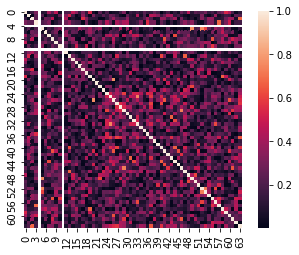

In [65]:
# res_non_ic
print("results of model w/o IC")
sns.heatmap(data=res_non_ic, square=True)
print(np.mean(res_non_ic))

results of model with IC
0.20988212468451198


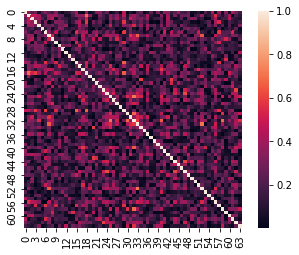

In [66]:
# res_ic
print("results of model with IC")
sns.heatmap(data=res_ic, square=True)
print(np.mean(res_ic))

In [67]:
# VGG16 series

# Cifar 10 

def load_model_vgg16(model, state_dict_path, print_layers=False):
    state_dict = torch.load(state_dict_path, map_location=device)
    state_dict["linear.0.weight"] = state_dict["classifier.6.weight"]
    state_dict["linear.0.bias"] = state_dict["classifier.6.bias"]
    del state_dict["classifier.6.weight"]
    del state_dict["classifier.6.bias"]

    model.load_state_dict(state_dict)
    model.to(device)
    if print_layers:
        for key in state_dict.keys():
            print(key)
    return model

def load_model_vgg16_ic(model, state_dict_path, print_layers=False):
    state_dict = torch.load(state_dict_path, map_location=device)
    state_dict["linear.0.weight"] = state_dict["classifier.7.weight"]
    state_dict["linear.0.bias"] = state_dict["classifier.7.bias"]
    del state_dict["classifier.7.weight"]
    del state_dict["classifier.7.bias"]

    model.load_state_dict(state_dict)
    model.to(device)
    if print_layers:
        for key in state_dict.keys():
            print(key)
    return model

print("Experiment: model: vgg16; dataset: cifar10")

model = load_model_vgg16(
    vgg.vgg16_bn(num_classes=10),
    os.path.join(model_dir, "vgg16/cifar10_vgg16_best.pth"), 
#     True, 
)

model_ic = load_model_vgg16_ic(
    vgg.vgg16_bn_ic(num_classes=10),
    os.path.join(model_dir, "vgg16/cifar10_vgg16_ic_best.pth"),
#     True, 
)

_, test_loader = cifar10_dataset()

print(model)
print(dir(model))

res = run_experiment(model, model_ic, test_loader)
res_non_ic = res["res_non_ic"]
res_ic = res["res_ic"]

Experiment: model: vgg16; dataset: cifar10
INFO: Creating VGG-16 Model
INFO: Creating VGG-16 Model with IC layer
INFO: Loading CIFAR10 training dataset
Files already downloaded and verified
INFO: Loading CIFAR10 test dataset
Files already downloaded and verified
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3)

IndexError: list index out of range

In [ ]:
# res_non_ic
print("results of model w/o IC")
sns.heatmap(data=res_non_ic, square=True)
print(np.mean(res_non_ic))

In [ ]:
# res_ic
print("results of model with IC")
sns.heatmap(data=res_ic, square=True)
print(np.mean(res_ic))

In [ ]:
# Cifar 100

print("Experiment: model: vgg16; dataset: cifar100")

model = load_model(
    vgg.vgg16_bn(num_classes=100),
    os.path.join(model_dir, "vgg16/cifar100_vgg16_best.pth"),
#     True, 
)

model_ic = load_model(
    vgg.vgg16_bn_ic(num_classes=100),
    os.path.join(model_dir, "vgg16/cifar100_vgg16_ic_best.pth"),
#     True, 
)

_, test_loader = cifar100_dataset()

res = run_experiment(model, model_ic, test_loader)
res_non_ic = res["res_non_ic"]
res_ic = res["res_ic"]

In [ ]:
# res_non_ic
print("results of model w/o IC")
sns.heatmap(data=res_non_ic, square=True)
print(np.mean(res_non_ic))

In [ ]:
# res_ic
print("results of model with IC")
sns.heatmap(data=res_ic, square=True)
print(np.mean(res_ic))

In [ ]:
# DenseNet series

# Cifar 10 

print("Experiment: model: densenet40; dataset: cifar10")

model = load_model(
    densenet.densenet40(num_classes=10),
    os.path.join(model_dir, "densenet40/cifar10_densenet40_best.pth"), 
#     True, 
)

model_ic = load_model(
    densenet.densenet40_ic(num_classes=10),
    os.path.join(model_dir, "densenet40/cifar10_densenet40_ic_best.pth"),
#     True, 
)

_, test_loader = cifar10_dataset()

res = run_experiment(model, model_ic, test_loader)
res_non_ic = res["res_non_ic"]
res_ic = res["res_ic"]

In [ ]:
# res_non_ic
print("results of model w/o IC")
sns.heatmap(data=res_non_ic, square=True)
print(np.mean(res_non_ic))

In [ ]:
# res_ic
print("results of model with IC")
sns.heatmap(data=res_ic, square=True)
print(np.mean(res_ic))

In [ ]:
# Cifar 100

print("Experiment: model: densenet40; dataset: cifar100")

model = load_model(
    densenet.densenet40(num_classes=100),
    os.path.join(model_dir, "densenet40/cifar100_densenet40_best.pth"),
#     True, 
)

model_ic = load_model(
    densenet.densenet40_ic(num_classes=100),
    os.path.join(model_dir, "densenet40/cifar100_densenet40_ic_best.pth"),
#     True, 
)

_, test_loader = cifar100_dataset()

res = run_experiment(model, model_ic, test_loader)
res_non_ic = res["res_non_ic"]
res_ic = res["res_ic"]

In [ ]:
# res_non_ic
print("results of model w/o IC")
sns.heatmap(data=res_non_ic, square=True)
print(np.mean(res_non_ic))

In [ ]:
# res_ic
print("results of model with IC")
sns.heatmap(data=res_ic, square=True)
print(np.mean(res_ic))

In [ ]:
# GoogleNet series

# Cifar 10 

print("Experiment: model: googlenet; dataset: cifar10")

model = load_model(
    googlenet.googlenet(num_classes=10),
    os.path.join(model_dir, "googlenet/cifar10_googlenet_best.pth"), 
#     True, 
)

model_ic = load_model(
    googlenet.googlenet_ic(num_classes=10),
    os.path.join(model_dir, "googlenet/cifar10_googlenet_ic_best.pth"),
#     True, 
)

_, test_loader = cifar10_dataset()

res = run_experiment(model, model_ic, test_loader)
res_non_ic = res["res_non_ic"]
res_ic = res["res_ic"]


In [ ]:
# res_non_ic
print("results of model w/o IC")
sns.heatmap(data=res_non_ic, square=True)
print(np.mean(res_non_ic))

In [ ]:
# res_ic
print("results of model with IC")
sns.heatmap(data=res_ic, square=True)
print(np.mean(res_ic))


In [ ]:
# Cifar 100

print("Experiment: model: googlenet; dataset: cifar100")

model = load_model(
    googlenet.googlenet(num_classes=100),
    os.path.join(model_dir, "googlenet/cifar100_googlenet_best.pth"),
#     True, 
)

model_ic = load_model(
    googlenet.googlenet_ic(num_classes=100),
    os.path.join(model_dir, "googlenet/cifar100_googlenet_ic_best.pth"),
#     True, 
)

_, test_loader = cifar100_dataset()

res = run_experiment(model, model_ic, test_loader)
res_non_ic = res["res_non_ic"]
res_ic = res["res_ic"]

In [ ]:
# res_non_ic
print("results of model w/o IC")
sns.heatmap(data=res_non_ic, square=True)
print(np.mean(res_non_ic))

In [ ]:
# res_ic
print("results of model with IC")
sns.heatmap(data=res_ic, square=True)
print(np.mean(res_ic))